### Initial reading function I/Q ###

In [30]:
!pip install pandas
!pip install numpy
!pip install seaborn

Total de amostras I/Q complexas lidas: 2500000

Leitura concluída com sucesso.


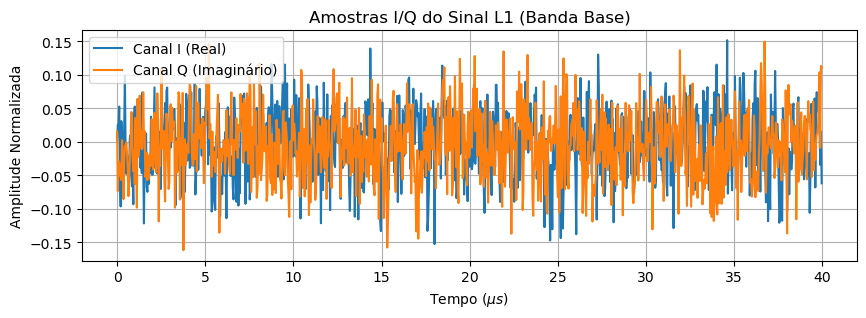

Média (deve ser perto de 0): -0.00-0.00j
Max valor: 0.33757296204566956
Min valor: 0.0


In [31]:
# =================================================================
# 1. IMPORTS E CONFIGURAÇÃO
# =================================================================
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Parâmetros do Sinal GPS (TEXBAT) ---
F_s = 25e6        # Taxa de amostragem: 25 MHz (Amostras/segundo)
F_IF = 0          # IMPORTANTE: Para ds7.bin (I/Q Complexo), F_IF é 0 (Banda Base)!
data_type = np.int16 # Formato dos dados: Inteiro de 16 bits (signed)

# --- Caminho do Arquivo ---
file_path = 'ds7.bin' 

# =================================================================
# 2. FUNÇÃO DE LEITURA OTIMIZADA
# =================================================================
def read_and_process_iq_data(file_path, data_type, num_samples_to_read=None):
    """
    Lê uma quantidade específica de amostras I/Q complexas diretamente do disco.
    """
    if num_samples_to_read is None:
        count_raw = -1 
    else:
        count_raw = int(num_samples_to_read * 2)

    try:
        raw_data = np.fromfile(file_path, dtype=data_type, count=count_raw)
    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado no caminho: {file_path}")
        return np.array([])
    
    if len(raw_data) < 2:
        print("AVISO: Dados lidos insuficientes.")
        return np.array([])

    # Separação e Normalização
    I_samples = raw_data[0::2].astype(np.float32) / 2**15
    Q_samples = raw_data[1::2].astype(np.float32) / 2**15
    
    # Sinal Complexo S(t)
    S_t = I_samples + 1j * Q_samples
    
    print(f"Total de amostras I/Q complexas lidas: {len(S_t)}")
    return S_t

# =================================================================
# 3. EXECUÇÃO
# =================================================================

# Ler 100ms para garantir dados suficientes para aquisição e tracking
NUM_SECONDS_FOR_ACQUISITION = 0.1 
num_samples_to_read = int(NUM_SECONDS_FOR_ACQUISITION * F_s)

# Chama a função
S_t_snippet = read_and_process_iq_data(
    file_path, 
    data_type, 
    num_samples_to_read=num_samples_to_read
)

if len(S_t_snippet) > 0:
    print(f"\nLeitura concluída com sucesso.")

# =================================================================
# 4. VERIFICAÇÃO E CORREÇÃO DE VARIÁVEL
# =================================================================
if len(S_t_snippet) > 0:
    # --- CORREÇÃO AQUI ---
    # Renomeamos para S_bb para as próximas células funcionarem
    S_bb = S_t_snippet 

    # Plot
    num_plot = 1000 
    time_vector = np.arange(num_plot) / F_s

    plt.figure(figsize=(10, 3))
    plt.plot(time_vector * 1e6, S_bb.real[:num_plot], label='Canal I (Real)')
    plt.plot(time_vector * 1e6, S_bb.imag[:num_plot], label='Canal Q (Imaginário)')
    plt.title('Amostras I/Q do Sinal L1 (Banda Base)')
    plt.xlabel('Tempo ($\mu s$)')
    plt.ylabel('Amplitude Normalizada')
    plt.legend()
    plt.grid(True)
    plt.show()

    # CHECK DE SANIDADE (Agora usando S_bb corretamente definido)
    print(f"Média (deve ser perto de 0): {np.mean(S_bb):.2f}")
    print(f"Max valor: {np.max(np.abs(S_bb))}")
    print(f"Min valor: {np.min(np.abs(S_bb))}")

### Testing if the reading function worked as planned ###


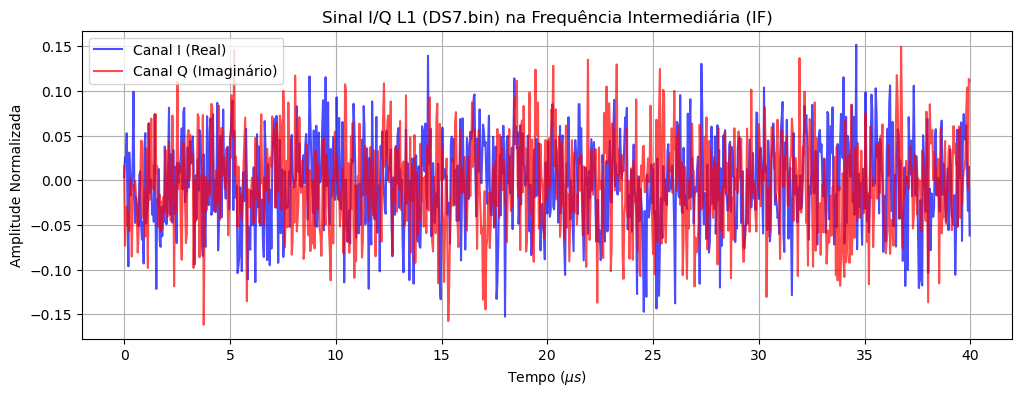

In [32]:
if len(S_t_snippet) > 0:
    # --- Parâmetros de Plotagem ---
    F_s = 25e6
    num_plot = 1000  # Quantidade de amostras para visualizar
    
    # 1. Crie o vetor de tempo
    # Usamos np.arange para criar um vetor de tempo em microssegundos (μs) para melhor visualização.
    time_vector_us = np.arange(num_plot) / F_s * 1e6

    # 2. Plotar
    plt.figure(figsize=(12, 4))
    
    # Plota o Canal I (Parte Real do sinal complexo)
    plt.plot(time_vector_us, S_t_snippet.real[:num_plot], 
             label='Canal I (Real)', 
             color='blue', 
             alpha=0.7)
             
    # Plota o Canal Q (Parte Imaginária do sinal complexo)
    plt.plot(time_vector_us, S_t_snippet.imag[:num_plot], 
             label='Canal Q (Imaginário)', 
             color='red', 
             alpha=0.7)
             
    plt.title('Sinal I/Q L1 (DS7.bin) na Frequência Intermediária (IF)')
    plt.xlabel('Tempo ($\mu s$)') # μs é microssegundo
    plt.ylabel('Amplitude Normalizada')
    plt.legend()
    plt.grid(True)
    plt.show()

#

### Downconversion ###

Deslocar a frequência de um sinal de uma Frequência Intermediária (IF) mais alta para uma frequência próxima de zero hertz (Banda Base).

No TEXBAT o sinal GPS L1 foi capturado e convertido para uma frequência intermediária de 10MHz, esse downconversio é realizado para 
fazer o shift do sinal para a Banda Base. 

Fazemos o downconversion para podermos gerar um pico de correlação claro e detectável, já que com uma frequências muito altas a amplitude é cancelada, pois a soma de uma senoidal ao longo de mutiplos ciclos é 0.

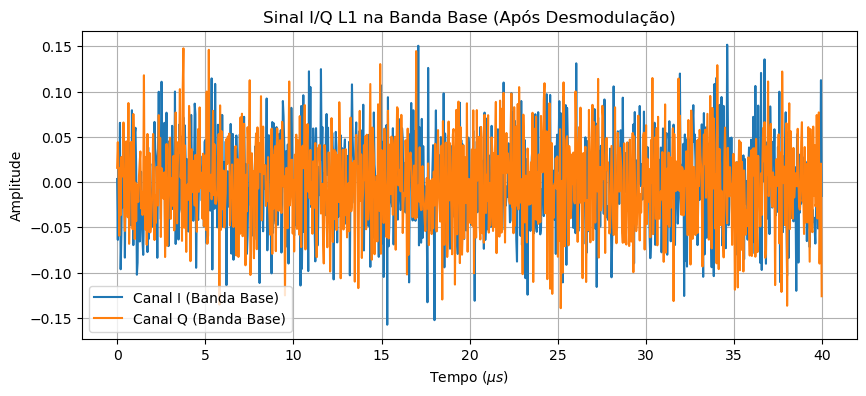

In [33]:
# CÉLULA 3: DOWNCONVERSION (Fase 2.2 - Etapa 1)

# Parâmetros
F_s = 25e6
F_IF = 10e6
S_t = S_t_snippet # Usamos o trecho de 1 ms

# 1. Crie o vetor de tempo
# np.arange cria um vetor de tempo, onde o último elemento não é incluído, por isso len(S_t)
t = np.arange(len(S_t)) / F_s

# 2. Crie a portadora local complexa (exponencial complexa)
# Sinais e Sistemas: Multiplicação por e^(-j * 2 * pi * F_IF * t)
local_carrier = np.exp(-1j * 2 * np.pi * F_IF * t)

# 3. Desmodulação (Downconversion)
S_bb = S_t * local_carrier

# Verificação: O sinal S_bb deve ter amplitude máxima em 0 Hz (Banda Base)
plt.figure(figsize=(10, 4))
plt.plot(t[:1000] * 1e6, S_bb.real[:1000], label='Canal I (Banda Base)')
plt.plot(t[:1000] * 1e6, S_bb.imag[:1000], label='Canal Q (Banda Base)')
plt.title('Sinal I/Q L1 na Banda Base (Após Desmodulação)')
plt.xlabel('Tempo ($\mu s$)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#

### Filtro Passa-baixo ###

In [34]:
from scipy.signal import butter, lfilter

def low_pass_filter(signal, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

# Aplicação
# Cutoff em 2.5 MHz (suficiente para o lóbulo principal do GPS L1)
S_bb_filtered = low_pass_filter(S_bb, 2.5e6, F_s)

# Agora use S_bb_filtered nas funções de Acquisition e Tracking

### Aquisição ###

Descobrir quais satélites estão visíveis e onde eles estão.

3 Passos:
- Gerador do código C/A
- PCPS (Código para testar as diferentes fases)
- Plot do pico

### Gerador do C/A ###

In [35]:
import numpy as np

# --- 1. A FUNÇÃO CORRIGIDA (GARANTA QUE ESTÁ USANDO ESTA) ---
def ca_code_check(prn):
    g2_taps = [
        [2,6], [3,7], [4,8], [5,9], [1,9], [2,10], [1,8], [2,9], [3,10], [2,3],
        [3,4], [5,6], [6,7], [7,8], [8,9], [9,10], [1,4], [2,5], [3,6], [4,7],
        [5,8], [6,9], [1,3], [4,6], [5,7], [6,8], [7,9], [8,10], [1,6], [2,7],
        [3,8], [4,9]
    ]
    
    # !!! AQUI ESTÁ A CORREÇÃO CRÍTICA: dtype=int !!!
    g1 = np.ones(10, dtype=int)
    g2 = np.ones(10, dtype=int)
    code = []

    for _ in range(1023):
        out_g1 = g1[-1]
        idx1 = g2_taps[prn-1][0] - 1
        idx2 = g2_taps[prn-1][1] - 1
        out_g2 = g2[idx1] ^ g2[idx2]
        code.append(out_g1 ^ out_g2)
        
        feed_g1 = g1[2] ^ g1[9]
        g1 = np.roll(g1, 1)
        g1[0] = feed_g1
        
        feed_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]
        g2 = np.roll(g2, 1)
        g2[0] = feed_g2

    return np.array(code) * 2 - 1

# --- 2. O TESTE DE VERIFICAÇÃO ---
print("--- TESTE UNITÁRIO: GERADOR C/A ---")

# Gera o código para o PRN 1
prn1_sequence = ca_code_check(1)

# Gabarito (Os primeiros 10 chips do PRN 1 segundo a norma IS-GPS-200)
# 1 = 1, 0 = -1
gabarito = np.array([1, 1, -1, -1, 1, -1, -1, -1, -1, -1])
teste = prn1_sequence[:10]

print(f"Primeiros 10 chips gerados: {teste}")
print(f"Primeiros 10 chips REAIS:   {gabarito}")

if np.array_equal(teste, gabarito):
    print("\n✅ SUCESSO: A lógica matemática do gerador está PERFEITA.")
else:
    print("\n❌ FALHA: O gerador está criando uma sequência errada.")

print(f"Tamanho total da sequência: {len(prn1_sequence)} (Deve ser 1023)")

--- TESTE UNITÁRIO: GERADOR C/A ---
Primeiros 10 chips gerados: [ 1  1 -1 -1  1 -1 -1 -1 -1 -1]
Primeiros 10 chips REAIS:   [ 1  1 -1 -1  1 -1 -1 -1 -1 -1]

✅ SUCESSO: A lógica matemática do gerador está PERFEITA.
Tamanho total da sequência: 1023 (Deve ser 1023)



--- TESTE DE REAMOSTRAGEM ---
Amostras necessárias para 1ms: 25000
Amostras geradas: 25000
✅ Tamanho do vetor: CORRETO


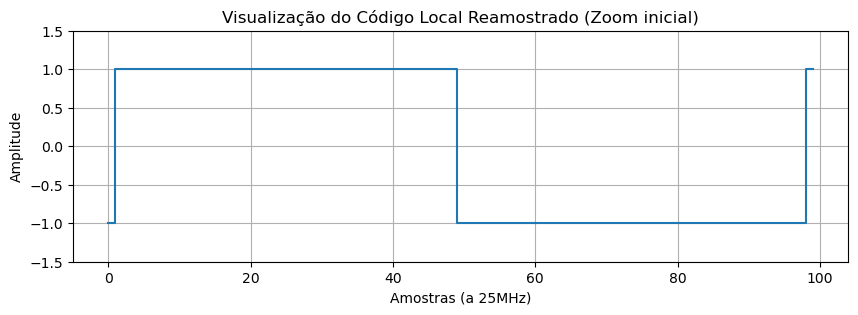

In [36]:
import matplotlib.pyplot as plt

def generate_local_code_check(prn, fs, num_samples):
    # Usa a função validada acima
    ca = ca_code_check(prn)
    chip_rate = 1.023e6
    code_indices = np.ceil(np.arange(num_samples) * (chip_rate / fs)).astype(int) - 1
    code_indices = np.mod(code_indices, 1023)
    return ca[code_indices]

# Parâmetros do TEXBAT
fs_teste = 25e6
samples_1ms = int(fs_teste * 1e-3) # Deve ser 25.000

# Gera código local reamostrado
local_code = generate_local_code_check(1, fs_teste, samples_1ms)

print(f"\n--- TESTE DE REAMOSTRAGEM ---")
print(f"Amostras necessárias para 1ms: {samples_1ms}")
print(f"Amostras geradas: {len(local_code)}")

if len(local_code) == samples_1ms:
    print("✅ Tamanho do vetor: CORRETO")
else:
    print("❌ Tamanho do vetor: ERRADO")

# PLOT DE ZOOM (Para ver se os bits estão 'quadrados')
plt.figure(figsize=(10, 3))
# Plotamos apenas as primeiras 100 amostras (apenas ~4 chips de GPS)
plt.step(np.arange(100), local_code[:100], where='post')
plt.title("Visualização do Código Local Reamostrado (Zoom inicial)")
plt.xlabel("Amostras (a 25MHz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.show()

### PCPS ###

In [37]:
# CÉLULA 5: MOTOR DE AQUISIÇÃO COM DIAGNÓSTICO (DEBUG)
# --- Funções Auxiliares (Movidas da Célula 4) ---
# Você precisa garantir que a função ca_code também esteja aqui ou foi executada antes
import numpy as np 

def ca_code(prn):
    """
    Gera o código C/A (Coarse/Acquisition) para um dado PRN (1-32).
    """
    g2_taps = [
        [2,6], [3,7], [4,8], [5,9], [1,9], [2,10], [1,8], [2,9], [3,10], [2,3],
        [3,4], [5,6], [6,7], [7,8], [8,9], [9,10], [1,4], [2,5], [3,6], [4,7],
        [5,8], [6,9], [1,3], [4,6], [5,7], [6,8], [7,9], [8,10], [1,6], [2,7],
        [3,8], [4,9]
    ]
    g1 = np.ones(10, dtype=int)
    g2 = np.ones(10, dtype=int)
    code = []
    for _ in range(1023):
        out_g1 = g1[-1]
        idx1 = g2_taps[prn-1][0] - 1
        idx2 = g2_taps[prn-1][1] - 1
        out_g2 = g2[idx1] ^ g2[idx2] 
        code.append(out_g1 ^ out_g2)
        feed_g1 = g1[2] ^ g1[9]
        g1 = np.roll(g1, 1)
        g1[0] = feed_g1
        feed_g2 = g2[1] ^ g2[2] ^ g2[5] ^ g2[7] ^ g2[8] ^ g2[9]
        g2 = np.roll(g2, 1)
        g2[0] = feed_g2
    return np.array(code) * 2 - 1

def generate_local_code(prn, fs, num_samples):
    """
    Gera o código C/A reamostrado para a frequência de amostragem do sinal.
    """
    # Chama ca_code, por isso ela também precisa estar definida!
    ca = ca_code(prn) 
    # ca_code_check é a versão final que usamos anteriormente, mas vamos manter
    # o nome 'ca_code' aqui para evitar confusão de nomes de arquivo.
    
    t_code = 1e-3 # 1 ms
    chip_rate = 1.023e6
    
    # Índices fracionários do código para cada amostra do sinal
    code_indices = np.ceil(np.arange(num_samples) * (chip_rate / fs)).astype(int) - 1
    # Garante que não estoure o índice (loop circular)
    code_indices = np.mod(code_indices, 1023)
    
    return ca[code_indices]

# --- FUNÇÃO PRINCIPAL ---
def acquisition_debug(signal_bb, fs, search_prns=range(1, 33), doppler_range=(-10000, 10000), doppler_step=500):
    # ... O restante do código da sua função acquisition_debug permanece o mesmo ...
    # (A parte que você forneceu na sua solicitação)
    
    results = {} 
    
    # 1. PREPARAÇÃO DO SINAL (1ms)
    # ... (o resto da função acquisition_debug) ...
    
    samples_per_ms = int(fs * 1e-3)
    
    # Validação de Tamanho
    if len(signal_bb) < samples_per_ms:
        print(f"ERRO CRÍTICO: O sinal fornecido tem {len(signal_bb)} amostras, mas precisamos de {samples_per_ms} para 1ms.")
        return {}
    
    signal_1ms = signal_bb[:samples_per_ms]
    
    # Validação de Energia
    signal_energy = np.sum(np.abs(signal_1ms)**2)
    print(f"--- DIAGNÓSTICO INICIAL ---")
    print(f"Amostras por ms: {samples_per_ms}")
    print(f"Energia do sinal (1ms): {signal_energy:.4f}")
    if signal_energy == 0:
        print("ERRO CRÍTICO: O sinal de entrada é puramente ZEROS.")
        return {}

    t = np.arange(samples_per_ms) / fs
    doppler_bins = np.arange(doppler_range[0], doppler_range[1] + doppler_step, doppler_step)
    
    print(f"Buscando Doppler de {doppler_range[0]} a {doppler_range[1]} Hz (Passo: {doppler_step} Hz)")
    print(f"Iniciando varredura de PRNs...")
    
    potential_sats = []

    for prn in search_prns:
        # Gera código local (AGORA FUNCIONA!)
        local_code = generate_local_code(prn, fs, samples_per_ms) 
        
        # FFT do Código (Conjugado para correlação)
        fft_code_conj = np.conj(np.fft.fft(local_code))
        
        best_peak_val = 0
        best_doppler = 0
        best_code_phase = 0
        
        # --- LOOP DOPPLER ---
        for dop in doppler_bins:
            # Wipeoff: Remove a portadora estimada
            carrier_wave = np.exp(-1j * 2 * np.pi * dop * t)
            signal_doppler_comp = signal_1ms * carrier_wave
            
            # FFT do Sinal
            fft_signal = np.fft.fft(signal_doppler_comp)
            
            # Correlação Circular via Teorema da Convolução
            correlation = np.abs(np.fft.ifft(fft_signal * fft_code_conj))
            
            # Acha o máximo nessa frequência
            peak = np.max(correlation)
            
            if peak > best_peak_val:
                best_peak_val = peak
                best_doppler = dop
                best_code_phase = np.argmax(correlation)
                best_correlation_vector = correlation

        # --- CÁLCULO DA MÉTRICA (RATIO) ---
        if best_peak_val < 1e-9:
             continue 
             
        sorted_corr = np.sort(best_correlation_vector)
        noise_floor = np.mean(sorted_corr[:int(0.9 * len(sorted_corr))])
        
        if noise_floor == 0:
            peak_ratio = 0
        else:
            peak_ratio = best_peak_val / noise_floor

        # --- LOGICA DE DETECÇÃO ---
        THRESHOLD = 2.5 
        
        if peak_ratio > THRESHOLD:
            print(f"✅ PRN {prn:02d} DETECTADO! | Ratio: {peak_ratio:.2f} | Doppler: {best_doppler} Hz | Mag: {best_peak_val:.1f}")
            results[prn] = {
                'doppler': best_doppler,
                'code_phase': best_code_phase,
                'peak_ratio': peak_ratio,
                'magnitude': best_peak_val
            }
        
        elif peak_ratio > 1.8:
            potential_sats.append(f"PRN {prn:02d} (Ratio {peak_ratio:.2f}, Dop {best_doppler})")

    if not results:
        print("\n--- RESULTADO: NENHUM SATÉLITE CONFIRMADO ---")
        if potential_sats:
            print("Mas houveram candidatos 'mornos' (pode ser necessário baixar o Threshold):")
            print(potential_sats)
        else:
            print("Nenhum pico relevante encontrado. O sinal parece ruído puro para este código local.")

    return results

# --- EXECUÇÃO DO TESTE ---
# Garante que S_bb e F_s existem (da leitura anterior)
if 'S_bb' in locals() and len(S_bb) > 0 and 'F_s' in locals():
    acquired_sats = acquisition_debug(S_bb_filtered, F_s, search_prns=range(1, 33))
else:
    print("ERRO: Variáveis S_bb e/ou F_s não estão definidas. Rode a célula de leitura de arquivo primeiro.")

--- DIAGNÓSTICO INICIAL ---
Amostras por ms: 25000
Energia do sinal (1ms): 17.4370
Buscando Doppler de -10000 a 10000 Hz (Passo: 500 Hz)
Iniciando varredura de PRNs...
✅ PRN 01 DETECTADO! | Ratio: 4.51 | Doppler: 7500 Hz | Mag: 37.9
✅ PRN 02 DETECTADO! | Ratio: 4.52 | Doppler: -1500 Hz | Mag: 38.6
✅ PRN 03 DETECTADO! | Ratio: 4.36 | Doppler: 1000 Hz | Mag: 37.3
✅ PRN 04 DETECTADO! | Ratio: 4.26 | Doppler: 5500 Hz | Mag: 36.8
✅ PRN 05 DETECTADO! | Ratio: 4.64 | Doppler: -2500 Hz | Mag: 39.0
✅ PRN 06 DETECTADO! | Ratio: 4.28 | Doppler: -3000 Hz | Mag: 35.8
✅ PRN 07 DETECTADO! | Ratio: 4.31 | Doppler: -3000 Hz | Mag: 36.9
✅ PRN 08 DETECTADO! | Ratio: 4.34 | Doppler: 3000 Hz | Mag: 36.6
✅ PRN 09 DETECTADO! | Ratio: 4.27 | Doppler: -4500 Hz | Mag: 36.3
✅ PRN 10 DETECTADO! | Ratio: 4.38 | Doppler: 2000 Hz | Mag: 37.1
✅ PRN 11 DETECTADO! | Ratio: 5.50 | Doppler: 500 Hz | Mag: 46.6
✅ PRN 12 DETECTADO! | Ratio: 4.23 | Doppler: -8000 Hz | Mag: 35.9
✅ PRN 13 DETECTADO! | Ratio: 4.62 | Doppler: 10

### Plot dos picos ###

Plotando satélite PRN 1...


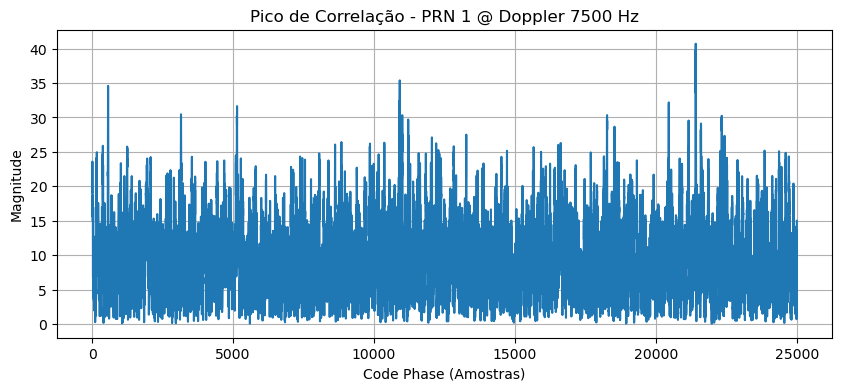

In [38]:
# CÉLULA 6: PLOT DE RESULTADO (CORRIGIDA)
import matplotlib.pyplot as plt
import numpy as np

def plot_acquisition(prn, signal_bb, fs, best_doppler):
    """Plota a correlação cruzada para o Doppler vencedor."""
    
    # Recalcula parâmetros básicos
    samples_per_ms = int(fs * 1e-3)
    signal_1ms = signal_bb[:samples_per_ms]
    t = np.arange(samples_per_ms) / fs
    
    # 1. Gera código local (IMPORTANTE: A Célula 4 deve ter sido rodada antes!)
    local_code = generate_local_code(prn, fs, samples_per_ms)
    
    # 2. Ajusta o sinal recebido removendo o Doppler estimado
    signal_shifted = signal_1ms * np.exp(-1j * 2 * np.pi * best_doppler * t)
    
    # 3. Correlação via FFT (Mesma lógica da aquisição)
    fft_sig = np.fft.fft(signal_shifted)
    fft_code = np.conj(np.fft.fft(local_code))
    corr = np.abs(np.fft.ifft(fft_sig * fft_code))
    
    # 4. Plotagem
    plt.figure(figsize=(10, 4))
    plt.plot(corr)
    plt.title(f"Pico de Correlação - PRN {prn} @ Doppler {best_doppler} Hz")
    plt.xlabel("Code Phase (Amostras)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

# --- EXECUÇÃO ---
# Verifica se a aquisição encontrou algo antes de tentar plotar
if 'acquired_sats' in locals() and acquired_sats:
    first_prn = list(acquired_sats.keys())[0]
    doppler_val = acquired_sats[first_prn]['doppler']
    
    print(f"Plotando satélite PRN {first_prn}...")
    plot_acquisition(first_prn, S_bb, F_s, doppler_val)
else:
    print("Nenhum satélite encontrado ou variável 'acquired_sats' não existe.")

A diferença entre o sinal e o ruído (SNR) está baixa. O pico é apenas um pouco maior que o barulho ao redor.


🌟 O SATÉLITE MAIS FORTE É O PRN 11!
Ratio: 5.50 | Doppler: 500 Hz


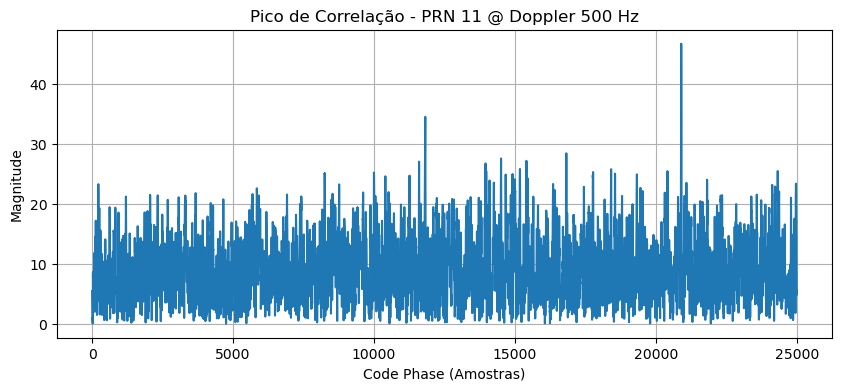

In [39]:
# --- MELHORIA: PLOTAR O SATÉLITE MAIS FORTE ---
if acquired_sats:
    # 1. Encontra o PRN com o maior 'peak_ratio' (o sinal mais forte)
    strongest_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    data = acquired_sats[strongest_prn]
    
    print(f"\n🌟 O SATÉLITE MAIS FORTE É O PRN {strongest_prn}!")
    print(f"Ratio: {data['peak_ratio']:.2f} | Doppler: {data['doppler']} Hz")
    
    # 2. Plota apenas esse campeão
    # Plota usando o sinal FILTRADO
    plot_acquisition(strongest_prn, S_bb_filtered, F_s, data['doppler'])
else:
    print("Nenhum satélite encontrado.")

Gerando gráfico com título para PRN 11...


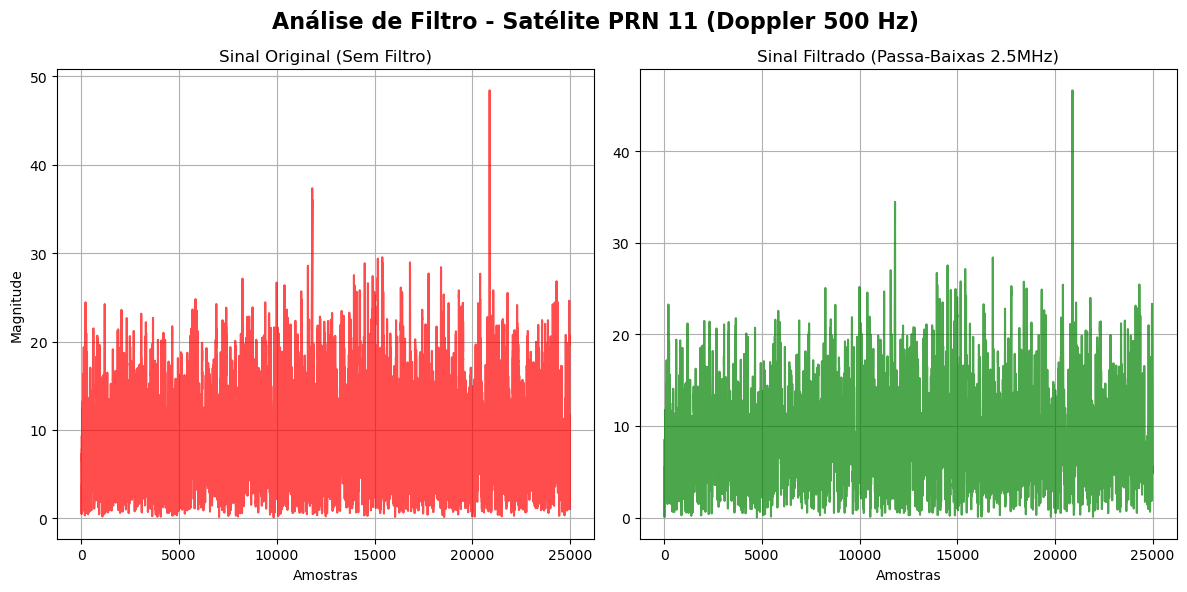

In [40]:
# CÉLULA: COMPARAÇÃO VISUAL COM TÍTULO DO SATÉLITE

def compare_filter_effect_with_title(prn, signal_raw, signal_filt, fs, doppler):
    samples_per_ms = int(fs * 1e-3)
    t = np.arange(samples_per_ms) / fs
    local_code = generate_local_code(prn, fs, samples_per_ms)
    
    # Função auxiliar interna
    def get_corr(sig):
        sig_1ms = sig[:samples_per_ms]
        sig_shifted = sig_1ms * np.exp(-1j * 2 * np.pi * doppler * t)
        fft_sig = np.fft.fft(sig_shifted)
        fft_code = np.conj(np.fft.fft(local_code))
        return np.abs(np.fft.ifft(fft_sig * fft_code))

    corr_raw = get_corr(signal_raw)
    corr_filt = get_corr(signal_filt)

    # --- INÍCIO DO PLOT ---
    plt.figure(figsize=(12, 6))
    
    # --- NOVIDADE AQUI: O TÍTULO GERAL DO SATÉLITE ---
    plt.suptitle(f"Análise de Filtro - Satélite PRN {prn} (Doppler {doppler} Hz)", fontsize=16, fontweight='bold')
    
    # Gráfico 1: Original
    plt.subplot(1, 2, 1)
    plt.plot(corr_raw, color='red', alpha=0.7)
    plt.title("Sinal Original (Sem Filtro)")
    plt.xlabel("Amostras")
    plt.ylabel("Magnitude")
    plt.grid(True)
    
    # Gráfico 2: Filtrado
    plt.subplot(1, 2, 2)
    plt.plot(corr_filt, color='green', alpha=0.7)
    plt.title("Sinal Filtrado (Passa-Baixas 2.5MHz)")
    plt.xlabel("Amostras")
    plt.grid(True)
    
    plt.tight_layout()
    # O adjust é necessário para o suptitle não ficar encavalado nos gráficos
    plt.subplots_adjust(top=0.88) 
    plt.show()

# --- EXECUÇÃO ---
if 'acquired_sats' in locals() and acquired_sats:
    # Pega o mais forte
    strongest_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    dop = acquired_sats[strongest_prn]['doppler']
    
    print(f"Gerando gráfico com título para PRN {strongest_prn}...")
    compare_filter_effect_with_title(strongest_prn, S_bb, S_bb_filtered, F_s, dop)

### Comparação dos picos entre o sinal original e o filtrado ###

Utilizamos o lfilter, função da biblioteca, e o que ela faz é basicamente alterar o formato do pico para tornar a 
análise mais simples. 

Observe que esse filtro dá um ligeiro deslocamento no sinal, entretanto, esse deslocamento não atrapalha nossas análises, pois:
- Para detecção de Spoofing o que importa é o formato do pico, ele estar atrasado ou adiantado não muda seu formato.
- Para o Tracking, o loop de rastreamento (DLL) não leva em conta o tempo absoluto, ele apenas procura ao longo da transmissão
do sinal o momento no qual ocorre o pico de energia do sinal.


Comparando pico do PRN 11...


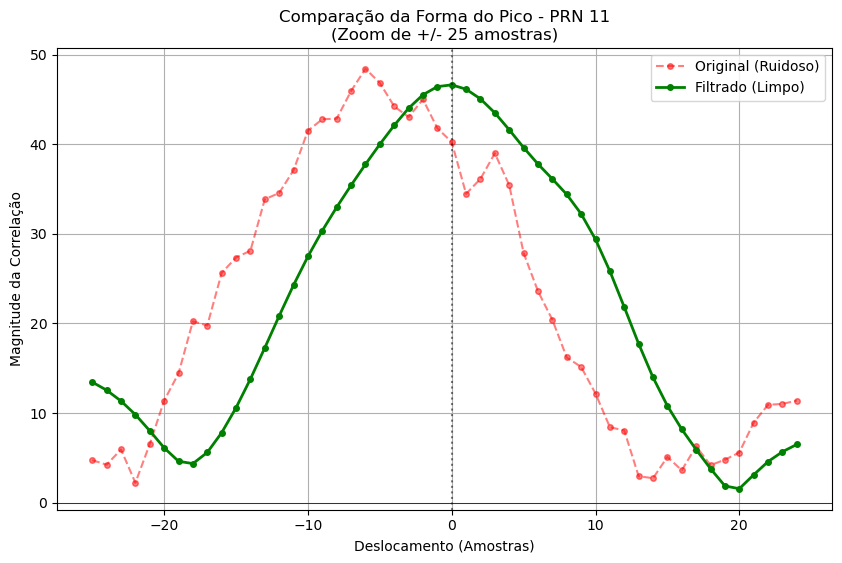

In [41]:
# CÉLULA 7: COMPARAÇÃO DE ZOOM (ORIGINAL vs FILTRADO)

def plot_peak_comparison(prn, signal_orig, signal_filt, fs, best_doppler, best_code_phase, window_size=20):
    """
    Plota o zoom do pico de correlação para dois sinais simultaneamente.
    Permite ver como o filtro limpa o ruído ao redor do triângulo.
    """
    samples_per_ms = int(fs * 1e-3)
    t = np.arange(samples_per_ms) / fs
    local_code = generate_local_code(prn, fs, samples_per_ms)
    
    # Função interna para calcular correlação e recortar o zoom
    def get_zoomed_correlation(sig):
        # 1. Recorta e Remove Doppler
        sig_1ms = sig[:samples_per_ms]
        sig_shifted = sig_1ms * np.exp(-1j * 2 * np.pi * best_doppler * t)
        
        # 2. Correlação (FFT)
        fft_sig = np.fft.fft(sig_shifted)
        fft_code = np.conj(np.fft.fft(local_code))
        corr = np.abs(np.fft.ifft(fft_sig * fft_code))
        
        # 3. Centralização (usando o phase da aquisição como âncora)
        shift_amount = (samples_per_ms // 2) - best_code_phase
        corr_centered = np.roll(corr, shift_amount)
        center_idx = samples_per_ms // 2
        
        # 4. Zoom
        zoom_corr = corr_centered[center_idx - window_size : center_idx + window_size]
        return zoom_corr

    # Processa os dois sinais
    zoom_orig = get_zoomed_correlation(signal_orig)
    zoom_filt = get_zoomed_correlation(signal_filt)
    
    # Eixo X (Deslocamento em amostras)
    zoom_x = np.arange(-window_size, window_size)

    # PLOT
    plt.figure(figsize=(10, 6))
    
    # Plot do Original (Vermelho, tracejado para ver o fundo)
    plt.plot(zoom_x, zoom_orig, 'r--o', alpha=0.5, label='Original (Ruidoso)', markersize=4)
    
    # Plot do Filtrado (Verde, linha cheia)
    plt.plot(zoom_x, zoom_filt, 'g-o', linewidth=2, label='Filtrado (Limpo)', markersize=4)
    
    plt.title(f"Comparação da Forma do Pico - PRN {prn}\n(Zoom de +/- {window_size} amostras)")
    plt.xlabel("Deslocamento (Amostras)")
    plt.ylabel("Magnitude da Correlação")
    plt.legend()
    plt.grid(True)
    
    # Adiciona linhas guia para facilitar a análise visual
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linestyle=':', alpha=0.5)
    
    plt.show()

# --- EXECUÇÃO ---
if 'acquired_sats' in locals() and acquired_sats:
    # Escolhe o satélite mais forte automaticamente
    strongest_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    data = acquired_sats[strongest_prn]
    
    print(f"Comparando pico do PRN {strongest_prn}...")
    
    # Chama a função passando AMBOS os sinais
    # Certifique-se que S_bb e S_bb_filtered existem!
    plot_peak_comparison(
        strongest_prn, 
        S_bb,           # Sinal Original
        S_bb_filtered,  # Sinal Filtrado
        F_s, 
        data['doppler'], 
        data['code_phase'],
        window_size=25  # Zoom de 25 amostras (cobre ~1 chip para cada lado)
    )
else:
    print("Rode a aquisição primeiro.")

### Code Tracking ###

- DLL (Delay Lock Loop): Ajusta o Código (para alinhar os chips perfeitamente). Ele usa os correladores Early (E) e Late (L).
- PLL (Phase Lock Loop): Ajusta a Frequência/Fase (para remover o Doppler residual e a rotação de fase). Ele usa o correlador Prompt (P).

In [42]:
# CÉLULA 7: FUNÇÃO DE TRACKING (DLL + PLL) ATUALIZADA

def tracking(signal_input, fs, prn, init_doppler, init_code_phase, duration_sec=1.0):
    """
    Rastreia o sinal GPS.
    signal_input: Pode ser o S_bb (bruto) ou S_bb_filtered (limpo).
    """
    import numpy as np

    # 1. Configurações
    T_int = 0.001 # 1ms de integração
    samples_per_code = int(fs * T_int)

    # Define quantos blocos de 1ms processar
    # Proteção: nunca tenta ler mais do que o tamanho do sinal
    num_blocks = int(duration_sec / T_int)
    max_blocks = len(signal_input) // samples_per_code
    num_blocks = min(num_blocks, max_blocks)

    # 2. Gerar Código C/A
    # Usamos a função padrão 'ca_code' que corrigimos anteriormente
    # Se der erro aqui, certifique-se de rodar a Célula 4
    ca_seq = ca_code(prn)

    # Upsample (Repete os chips para bater com a taxa de amostragem)
    # Cria uma tabela de consulta para agilizar o processo
    code_table = np.repeat(ca_seq, np.ceil(samples_per_code / 1023).astype(int))[:samples_per_code]

    # 3. Listas para armazenar as Features
    I_P_list, Q_P_list = [], []
    I_E_list, Q_E_list = [], []
    I_L_list, Q_L_list = [], []
    freq_history = []

    # 4. Variáveis de Estado (PLL e DLL)
    carr_freq = init_doppler
    carr_phase = 0.0
    code_phase = init_code_phase
    # Espaçamento 0.5 chip para o correlator Early/Late
    early_late_samples = int(0.5 * (samples_per_code / 1023)) 

    current_idx = 0

    #print(f"--> Iniciando Tracking do PRN {prn} por {num_blocks/1000:.1f} segundos...")

    # --- LOOP DE RASTREAMENTO (Epoch a Epoch) ---
    for i in range(num_blocks):
        # Pegar 1ms de dados do sinal de entrada
        chunk = signal_input[current_idx : current_idx + samples_per_code]
        current_idx += samples_per_code

        # A) Carrier Wipeoff (Remover portadora)
        t = np.arange(samples_per_code) / fs
        local_carrier = np.exp(-1j * (2 * np.pi * carr_freq * t + carr_phase))
        baseband = chunk * local_carrier

        # B) Correlacionar (Prompt, Early, Late)
        shift_P = int(code_phase)
        shift_E = shift_P - early_late_samples
        shift_L = shift_P + early_late_samples

        # Rotaciona o código local (Roll é eficiente para shifts inteiros)
        code_P = np.roll(code_table, shift_P)
        code_E = np.roll(code_table, shift_E)
        code_L = np.roll(code_table, shift_L)

        # Integração (Soma dos produtos)
        corr_P = np.sum(baseband * code_P); i_p, q_p = np.real(corr_P), np.imag(corr_P)
        corr_E = np.sum(baseband * code_E); i_e, q_e = np.real(corr_E), np.imag(corr_E)
        corr_L = np.sum(baseband * code_L); i_l, q_l = np.real(corr_L), np.imag(corr_L)

        # --- GUARDAR DADOS ---
        I_P_list.append(i_p); Q_P_list.append(q_p)
        I_E_list.append(i_e); Q_E_list.append(q_e)
        I_L_list.append(i_l); Q_L_list.append(q_l)
        freq_history.append(carr_freq)

        # C) Discriminadores e Filtros
        # PLL (Costas Loop) para fase da portadora
        if i_p == 0: i_p = 1e-9 # Evita divisão por zero
        phi_err = np.arctan(q_p / i_p)

        # DLL (Non-coherent Early minus Late) para fase do código
        mag_E = np.sqrt(i_e**2 + q_e**2)
        mag_L = np.sqrt(i_l**2 + q_l**2)
        if (mag_E + mag_L) == 0: code_err = 0
        else: code_err = 0.5 * (mag_E - mag_L) / (mag_E + mag_L)

        # Atualizar NCOs (Ganhos simplificados para dados estáticos)
        carr_freq += phi_err * 5.0 # Ganho do PLL
        carr_phase += 2 * np.pi * carr_freq * T_int
        carr_phase %= (2 * np.pi)

        code_step = code_err * 2.0 # Ganho do DLL
        code_phase -= code_step

        # Limites circulares da fase do código (Buffer Circular)
        if code_phase >= samples_per_code: code_phase -= samples_per_code
        if code_phase < 0: code_phase += samples_per_code

    # Retorna o dicionário organizado
    return {
        "I_P": np.array(I_P_list), "Q_P": np.array(Q_P_list),
        "I_E": np.array(I_E_list), "Q_E": np.array(Q_E_list),
        "I_L": np.array(I_L_list), "Q_L": np.array(Q_L_list),
        "freq_history": np.array(freq_history)
    }

In [43]:
# CÉLULA 8: RODAR TRACKING COM SINAL FILTRADO

if 'acquired_sats' in locals() and acquired_sats:
    # 1. Seleciona o satélite mais forte
    best_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    params = acquired_sats[best_prn]
    
    # 2. Define duração
    # Recomendado: 1.0s para ter bastante pontos para as métricas SQM
    track_duration = 1.0 
    
    print(f"Iniciando rastreamento do PRN {best_prn}...")
    print(f"Doppler Inicial: {params['doppler']} Hz | Phase Inicial: {params['code_phase']}")
    
    # 3. Chama a função passando S_bb_filtered
    track_results = tracking(
        signal_input=S_bb_filtered,  # <--- O SEGREDO ESTÁ AQUI
        fs=F_s, 
        prn=best_prn, 
        init_doppler=params['doppler'], 
        init_code_phase=params['code_phase'], 
        duration_sec=track_duration
    )
    
    print("✅ Tracking finalizado com sucesso!")
    
else:
    print("❌ Rode a aquisição primeiro!")

Iniciando rastreamento do PRN 11...
Doppler Inicial: 500 Hz | Phase Inicial: 20898
✅ Tracking finalizado com sucesso!


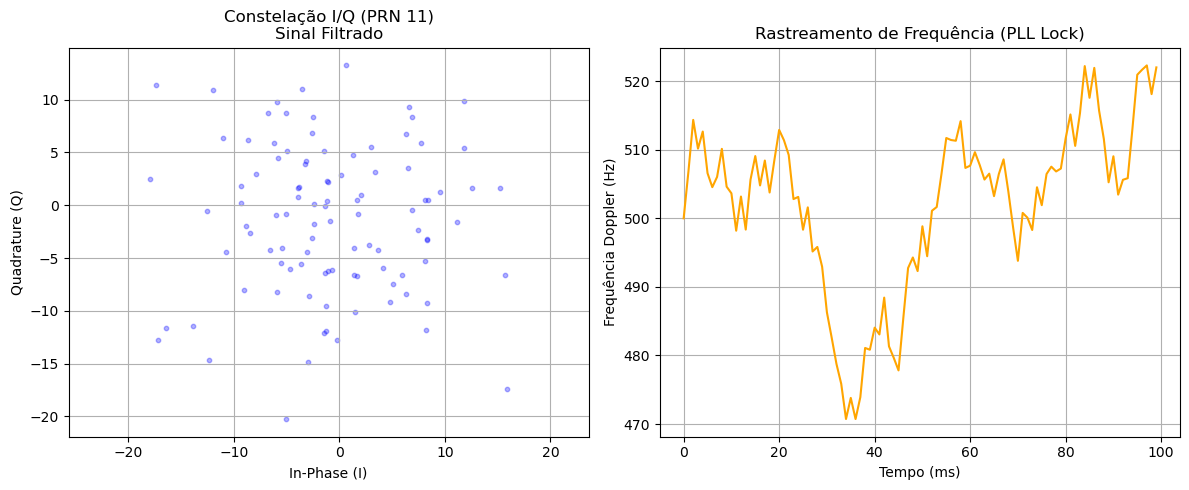

In [44]:
# CÉLULA 9: PLOT DA CONSTELAÇÃO (Check de Qualidade)

if 'track_results' in locals():
    I = track_results['I_P']
    Q = track_results['Q_P']
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Constelação
    plt.subplot(1, 2, 1)
    plt.scatter(I, Q, s=10, alpha=0.3, color='blue')
    plt.title(f"Constelação I/Q (PRN {best_prn})\nSinal Filtrado", fontsize=12)
    plt.xlabel("In-Phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True)
    plt.axis('equal') 
    
    # Plot 2: Estabilidade de Frequência
    plt.subplot(1, 2, 2)
    plt.plot(track_results['freq_history'], color='orange')
    plt.title("Rastreamento de Frequência (PLL Lock)")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Frequência Doppler (Hz)")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Extração de características ###

Extração de features
- SQM
- C/N0
- Doppler
- Largura do pico (Corr_Ratio)
- Simetria (Corr_Asym)

Essas características serão utilizadas para identificar os sinais legítimos de cada satélite.

In [45]:
# CÉLULA 10: EXTRAÇÃO DE FEATURES (SQM, C/N0, DOPPLER) - CORRIGIDA
import pandas as pd
import numpy as np

# --- 1. FUNÇÕES AUXILIARES DE CÁLCULO ---

def calculate_cn0(I_P, Q_P, T_int=0.001):
    """
    Calcula C/N0 (Estimativa de força do sinal).
    Usa a razão Variância/Média (Método M2M4 simplificado para sinais estáticos).
    """
    # Potência instantânea ao longo do tempo
    P = I_P**2 + Q_P**2
    
    mean_P = np.mean(P)
    var_P = np.var(P)
    
    # Evita divisão por zero em sinais perfeitos ou mortos
    if var_P == 0: return 0
    
    # Estimativa de SNR linear
    snr_linear = np.sqrt(mean_P**2 / var_P)
    
    # Converte para Hz (dividindo pelo tempo de integração)
    cn0_linear = snr_linear / T_int
    
    return 10 * np.log10(cn0_linear) if cn0_linear > 0 else 0

def analyze_correlation_shape(I_E, Q_E, I_L, Q_L, I_P, Q_P):
    """
    Métricas SQM (Signal Quality Monitoring).
    Detecta se o triângulo de correlação está "gordo" ou "torto" (sintoma de spoofing).
    """
    # Magnitudes
    E = np.sqrt(I_E**2 + Q_E**2)
    L = np.sqrt(I_L**2 + Q_L**2)
    P = np.sqrt(I_P**2 + Q_P**2)
    
    # Evita divisão por zero
    P_safe = np.where(P == 0, 1e-9, P)

    # 1. Ratio (Largura): (Early + Late) / Prompt
    # Se houver spoofing, o pico alarga e essa razão aumenta.
    ratio = (E + L) / P_safe
    
    # 2. Asymmetry (Distorção): (Early - Late) / Prompt
    # Se o spoofing vier de um lado, o pico entorta.
    asym = (E - L) / P_safe

    return {
        "corr_ratio_mean": np.mean(ratio),
        "corr_ratio_var": np.var(ratio), # A variância da métrica também é útil
        "corr_asym_mean": np.mean(asym),
        "corr_asym_var": np.var(asym)
    }

def analyze_doppler_stats(freq_history):
    """Analisa a estabilidade da frequência (Jitter do Doppler)."""
    if len(freq_history) < 2: return 0
    return np.std(freq_history)

# --- 2. FUNÇÃO GERADORA DO DATASET ---

def extract_features(signal_input, fs, prn, init_doppler, init_code_phase, label, duration_sec=1.0):
    """
    Roda o Tracking no sinal (já carregado e filtrado) e extrai as métricas.
    """
    print(f"--- Extraindo Features do PRN {prn} (Label: {label}) ---")
    
    # 1. RODA O TRACKING (Usando a função da Célula 7)
    # Note que passamos os valores iniciais vindos da Aquisição!
    track_results = tracking(
        signal_input, 
        fs, 
        prn, 
        init_doppler, 
        init_code_phase, 
        duration_sec=duration_sec
    )
    
    # Se o tracking falhar (retornar vazio ou poucos dados), retorna vazio
    if len(track_results['I_P']) < 10:
        print("Aviso: Tracking falhou ou gerou poucos pontos.")
        return pd.DataFrame()

    print("Calculando métricas SQM...")
    
    # 2. CÁLCULO DAS FEATURES
    # C/N0
    cn0 = calculate_cn0(track_results['I_P'], track_results['Q_P'])
    
    # Variação de Potência (Feature simples)
    power_var = np.var(track_results['I_P']**2 + track_results['Q_P']**2)
    
    # Métricas de Forma (SQM)
    sqm = analyze_correlation_shape(
        track_results['I_E'], track_results['Q_E'],
        track_results['I_L'], track_results['Q_L'],
        track_results['I_P'], track_results['Q_P']
    )
    
    # Estabilidade do Doppler
    doppler_std = analyze_doppler_stats(track_results['freq_history'])

    # 3. MONTAGEM DO DATAFRAME (LINHA ÚNICA PARA ESSE SATÉLITE)
    row = {
        "PRN": prn,
        "CN0": cn0,
        "Power_Var": power_var,
        "Corr_Ratio": sqm['corr_ratio_mean'],
        "Corr_Ratio_Var": sqm['corr_ratio_var'],
        "Corr_Asym": sqm['corr_asym_mean'],
        "Doppler_Std": doppler_std,
        "Label": label # 0 = Autêntico, 1 = Spoofing
    }
    
    print(f"✅ Sucesso! C/N0: {cn0:.2f} dB-Hz | Ratio: {sqm['corr_ratio_mean']:.3f}")
    
    # Retorna como DataFrame (uma linha)
    return pd.DataFrame([row])

### Extração das características do satélite 11 ###

Extraímos as características do satélite 11 já que ele vai ser nosso benchmark e quando tivermos nosso modelo completo vamos rodar 
o modelo produzido em todos os satélites.

In [46]:
# CÉLULA 11: GERANDO A TABELA DE DADOS

# Verifica se temos dados de aquisição
if 'acquired_sats' in locals() and acquired_sats:
    
    # Vamos pegar o melhor satélite (PRN 11 no seu caso)
    best_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    params = acquired_sats[best_prn]
    
    # --- CONFIGURAÇÃO DO CENÁRIO ---
    # Como estamos no início do arquivo (0-110s), o sinal é AUTÊNTICO (Label 0)
    current_label = 0 
    
    # Extrai as features
    df_features = extract_features(
        signal_input=S_bb_filtered,  # <--- USA O SINAL FILTRADO!
        fs=F_s,
        prn=best_prn,
        init_doppler=params['doppler'],
        init_code_phase=params['code_phase'],
        label=current_label,
        duration_sec=1.0 # 1 segundo de dados para ter estatística robusta
    )
    
    # Mostra a tabela final
    print("\n--- Tabela de Features Gerada ---")
    display(df_features) # 'display' deixa a tabela bonita no Jupyter
    
else:
    print("Rode a aquisição primeiro!")

--- Extraindo Features do PRN 11 (Label: 0) ---
Calculando métricas SQM...
✅ Sucesso! C/N0: 29.87 dB-Hz | Ratio: 2.910

--- Tabela de Features Gerada ---


,PRN,CN0,Power_Var,Corr_Ratio,Corr_Ratio_Var,Corr_Asym,Doppler_Std,Label
0,11,29.866643,12284.479558,2.910102,5.642512,0.20167,12.290286,0


### Prototipagem do classificador ###

Vamos utilizar o PRN 11 como mmodelo para testar se o código do classificador está implementado corretamente e se as métricas estão
coerentes com os resultados esperados.

Após o código rodar liso para o PRN 11, é só gerar o csv 

### Criação do dataset e treinamento ###

In [47]:
!pip install seaborn
!pip install scikit-learn

In [ ]:
# CÉLULA 13: GERADOR DE DATASET COM JANELAMENTO (CORRIGIDO)
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter

# --- Configurações do Filtro ---
def low_pass_filter(signal, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)

def process_sliding_windows(file_path, prn, start_doppler, start_phase, fs, 
                          window_duration=0.5, max_duration=160.0):
    
    # Configurações de Leitura
    samples_per_window = int(fs * window_duration)
    
    dataset_rows = []
    
    # Estado Inicial
    current_doppler = start_doppler
    current_code_phase = start_phase
    
    try:
        with open(file_path, 'rb') as f:
            print(f"--- Iniciando Processamento Janelado (PRN {prn}) ---")
            print(f"Janela: {window_duration}s | Duração Máx: {max_duration}s")
            
            # Cria o vetor de tempo
            time_steps = np.arange(0, max_duration, window_duration)
            
            # --- CORREÇÃO AQUI: Usamos enumerate para contar as iterações (i) ---
            for i, t_start in enumerate(time_steps):
                
                # 1. Leitura
                raw_data = np.fromfile(f, count=samples_per_window*2, dtype=np.int16)
                if len(raw_data) < samples_per_window*2:
                    print("Fim do arquivo alcançado.")
                    break
                
                # Complexo + Filtro
                I = raw_data[0::2].astype(np.float32) / 2**15
                Q = raw_data[1::2].astype(np.float32) / 2**15
                chunk_bb = I + 1j * Q
                chunk_filtered = low_pass_filter(chunk_bb, 2.5e6, fs)
                
                # 2. Label
                current_label = 0 if t_start < 110 else 1
                
                # 3. Tracking
                track_res = tracking(
                    chunk_filtered, fs, prn, 
                    current_doppler, current_code_phase, 
                    duration_sec=window_duration
                )
                
                if len(track_res['I_P']) < 10:
                    # Se perder o tracking, tenta manter o Doppler antigo
                    continue
                
                # Atualiza para a próxima
                current_doppler = np.mean(track_res['freq_history'][-50:])
                
                # 4. Features
                cn0 = calculate_cn0(track_res['I_P'], track_res['Q_P'])
                sqm = analyze_correlation_shape(
                    track_res['I_E'], track_res['Q_E'],
                    track_res['I_L'], track_res['Q_L'],
                    track_res['I_P'], track_res['Q_P']
                )
                dop_std = analyze_doppler_stats(track_res['freq_history'])
                
                # 5. Salva
                dataset_rows.append({
                    "Time": t_start,
                    "PRN": prn,
                    "CN0": cn0,
                    "Corr_Ratio": sqm['corr_ratio_mean'],
                    "Corr_Ratio_Var": sqm['corr_ratio_var'],
                    "Corr_Asym": sqm['corr_asym_mean'],
                    "Doppler_Std": dop_std,
                    "Label": current_label
                })
                
                # --- LOG LIMPO ---
                # Imprime a cada 50 janelas (se janela=0.2s, isso é a cada 10s)
                if i % 50 == 0:
                    print(f"Progresso: {t_start:.1f}s / {max_duration}s | C/N0: {cn0:.1f} dB | Label: {current_label}")

    except KeyboardInterrupt:
        print("\n🛑 Processamento interrompido pelo usuário!")
        # Retorna o que já conseguiu processar até agora
        return pd.DataFrame(dataset_rows)
        
    except Exception as e:
        print(f"Erro no processamento: {e}")
        
    return pd.DataFrame(dataset_rows)

# --- EXECUÇÃO ---
if 'acquired_sats' in locals() and acquired_sats:
    best_prn = max(acquired_sats, key=lambda k: acquired_sats[k]['peak_ratio'])
    params = acquired_sats[best_prn]
    
    print(f"Gerando dataset contínuo para PRN {best_prn}...")
    
    df_full = process_sliding_windows(
        'ds7.bin', 
        best_prn, 
        params['doppler'], 
        params['code_phase'], 
        F_s, 
        window_duration=0.2, 
        max_duration=270.0 # Pode aumentar para 300 se quiser ver mais do ataque
    )
    
    print("\n--- Dataset Final Gerado ---")
    display(df_full.tail())
    
    # Salva
    if not df_full.empty:
        df_full.to_csv('features_gps_spoofing.csv', index=False)
        print("Salvo em 'features_gps_spoofing.csv'")
else:
    print("Rode a aquisição primeiro!")

Gerando dataset contínuo para PRN 11...
--- Iniciando Processamento Janelado (PRN 11) ---
Janela: 0.2s | Duração Máx: 350.0s
Progresso: 0.0s / 350.0s | C/N0: 30.1 dB | Label: 0
Progresso: 10.0s / 350.0s | C/N0: 29.9 dB | Label: 0
Progresso: 20.0s / 350.0s | C/N0: 29.9 dB | Label: 0
Progresso: 30.0s / 350.0s | C/N0: 30.4 dB | Label: 0
Progresso: 40.0s / 350.0s | C/N0: 30.1 dB | Label: 0
Progresso: 50.0s / 350.0s | C/N0: 30.5 dB | Label: 0
Progresso: 60.0s / 350.0s | C/N0: 29.9 dB | Label: 0
Progresso: 70.0s / 350.0s | C/N0: 29.9 dB | Label: 0
Progresso: 80.0s / 350.0s | C/N0: 29.8 dB | Label: 0
Progresso: 90.0s / 350.0s | C/N0: 30.2 dB | Label: 0
Progresso: 100.0s / 350.0s | C/N0: 30.1 dB | Label: 0
Progresso: 110.0s / 350.0s | C/N0: 30.1 dB | Label: 1
Progresso: 120.0s / 350.0s | C/N0: 29.7 dB | Label: 1
Progresso: 130.0s / 350.0s | C/N0: 30.1 dB | Label: 1
Progresso: 140.0s / 350.0s | C/N0: 29.8 dB | Label: 1
Progresso: 150.0s / 350.0s | C/N0: 30.7 dB | Label: 1
Progresso: 160.0s / 35

,Time,PRN,CN0,Corr_Ratio,Corr_Ratio_Var,Corr_Asym,Doppler_Std,Label
1347,269.4,11,30.259567,3.239497,9.558480,0.144794,17.843205,1
1348,269.6,11,29.913320,2.859083,6.566930,0.121761,29.034630,1
1349,269.8,11,30.354986,2.577910,3.671551,0.061545,16.741591,1
1350,270.0,11,30.384047,2.841736,8.662872,0.083633,18.721462,1
1351,270.2,11,30.699147,2.652762,5.904881,0.061692,19.210944,1


Salvo em 'features_gps_spoofing.csv'


### Análise do cvs ###

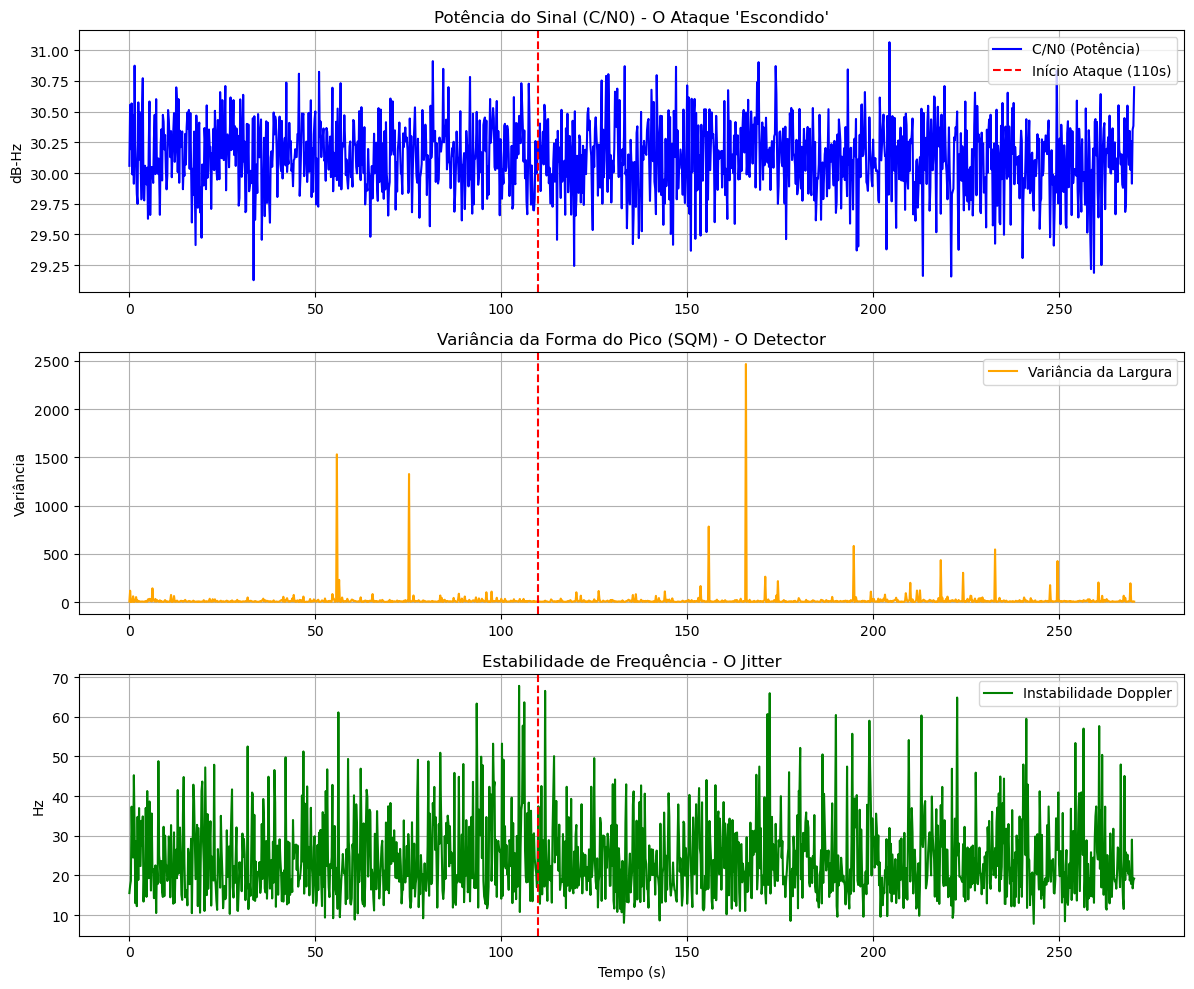

In [51]:
# CÉLULA 14: PLOTANDO A VERDADE ESCONDIDA
import matplotlib.pyplot as plt
import pandas as pd

# Carrega o seu CSV salvo
df = pd.read_csv('features_gps_spoofing.csv')

plt.figure(figsize=(12, 10))

# 1. C/N0 (O que você viu: quase não muda)
plt.subplot(3, 1, 1)
plt.plot(df['Time'], df['CN0'], color='blue', label='C/N0 (Potência)')
plt.axvline(110, color='r', linestyle='--', label='Início Ataque (110s)')
plt.title("Potência do Sinal (C/N0) - O Ataque 'Escondido'")
plt.ylabel("dB-Hz")
plt.legend()
plt.grid(True)

# 2. Ratio Variance (Onde o ataque deve aparecer)
plt.subplot(3, 1, 2)
plt.plot(df['Time'], df['Corr_Ratio_Var'], color='orange', label='Variância da Largura')
plt.axvline(110, color='r', linestyle='--')
plt.title("Variância da Forma do Pico (SQM) - O Detector")
plt.ylabel("Variância")
plt.legend()
plt.grid(True)

# 3. Doppler Std (A confusão do Tracking)
plt.subplot(3, 1, 3)
plt.plot(df['Time'], df['Doppler_Std'], color='green', label='Instabilidade Doppler')
plt.axvline(110, color='r', linestyle='--')
plt.title("Estabilidade de Frequência - O Jitter")
plt.ylabel("Hz")
plt.xlabel("Tempo (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()